In [ ]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #allows truncated images
from scipy import ndimage
import keras
from keras.models import Sequential, Model, Input, load_model
from tensorflow.python.framework.ops import Tensor
from keras.layers import Dense, Dropout, Flatten, Activation, Average, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
import tensorboard 
from keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt 
from sklearn import model_selection, metrics
from keras.utils import to_categorical
from tqdm import tqdm
import seaborn as sn
import pickle
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import sklearn
import glob
from keras import backend as K

Using TensorFlow backend.


In [ ]:
img_filename = 'images_1_highres.pickle'
second_img_filename = 'images_2_highres.pickle'

#label_filename = 'pickled_labels'

label_filename = 'labels_1.pickle'
second_label_filename = 'labels_2.pickle'

with open(img_filename, 'rb') as source:
    first_imgs = pickle.load(source)
with open(second_img_filename, 'rb') as source:
    second_imgs = pickle.load(source)

X = np.concatenate((first_imgs,second_imgs),axis=0)

with open(label_filename, 'rb') as source1:
    first_labels = pickle.load(source1)
with open(second_label_filename, 'rb') as source2:
    second_labels = pickle.load(source2)
    second_labels = [i[1] for i in second_labels]

y = np.concatenate((first_labels,second_labels),axis=0)


print(set(y))

{'Italian honey bee', 'Bombus fraternus', 'Bombus affinis', 'Bombus griseocollis', 'Russian honey bee', 'Bombus vagans', '1 Mixed local stock 2', 'Bombus citrinus', 'Bombus fervidus', 'Bombus impatiens', 'Bombus pensylvanicus', 'Bombus perplexus', 'Bombus bimaculatus', 'Carniolan honey bee', 'Bombus rufocinctus', 'Bombus auricomus', 'Western honey bee', 'VSH Italian honey bee', 'Apis mellifera'}


In [ ]:
#remove classes with under 200 samples
classes_to_remove = ['Bombus fraternus','Bombus perplexus']
indices_to_remove = []
for i,label in enumerate(y):
  if label in classes_to_remove:
    indices_to_remove.append(i)

y = np.delete(y,indices_to_remove)
X = np.delete(X,indices_to_remove,axis=0)

#rename apis mellifera to western honey bee
y = np.where(y=='Apis mellifera','Western honey bee',y)

In [ ]:
bee_names = np.array(y)
assert(len(X)==len(y))
number_classes = len(set(y))

In [ ]:
undersampling_counts = {'1 Mixed local stock 2': 472,
 'Bombus affinis': 462,
 'Bombus auricomus': 1000,
 'Bombus bimaculatus': 1000,
 'Bombus citrinus': 241,
 'Bombus fervidus': 774,
 'Bombus griseocollis': 1000,
 'Bombus impatiens': 1000,
 'Bombus pensylvanicus': 742,
 'Bombus rufocinctus': 199,
 'Bombus vagans': 287,
 'Carniolan honey bee': 501,
 'Italian honey bee': 1000,
 'Russian honey bee': 527,
 'VSH Italian honey bee': 199,
 'Western honey bee': 1000}

In [ ]:
#Undersampling 
index_list_again = np.array([i for i in range(len(X))])
rus = RandomUnderSampler(random_state=42, sampling_strategy=undersampling_counts)
 
Xresampled, yresampled = rus.fit_resample(
    index_list_again.reshape(-1, 1), y
)
Xresampled = Xresampled.flatten()
print(Xresampled.shape)
Xresampled = X[Xresampled]

(10404,)


In [ ]:
#SMOTE again
index_list_again = np.array([i for i in range(len(Xresampled))])
sm = SMOTE(random_state=42)
 
Xresampled_again, yresampled_again = sm.fit_resample(index_list_again.reshape(-1, 1), yresampled)
Xresampled_again = Xresampled_again.flatten()
print(Xresampled_again.shape)
Xresampled_again = Xresampled[Xresampled_again]

(16000,)


In [ ]:
label_to_number = {'1 Mixed local stock 2': 0,
 'Bombus affinis': 1,
 'Bombus auricomus': 2,
 'Bombus bimaculatus': 3,
 'Bombus citrinus': 4,
 'Bombus fervidus': 5,
 'Bombus griseocollis': 6,
 'Bombus impatiens': 7,
 'Bombus pensylvanicus': 8,
 'Bombus rufocinctus': 9,
 'Bombus vagans': 10,
 'Carniolan honey bee': 11,
 'Italian honey bee': 12,
 'Russian honey bee': 13,
 'VSH Italian honey bee': 14,
 'Western honey bee': 15}

In [ ]:
#change labels to numbers for one-hot encoding
new_y = []
for label in yresampled_again:
  new_label = label_to_number[label]
  new_y.append(new_label)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    Xresampled_again, new_y, test_size=0.2, random_state=42
)

print(f'Files in train: {len(X_train)}. Files in test: {len(X_test)}')

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
np.unique(y_test)
input_shape = X_train[0,:,:,:].shape
model_input = Input(shape=input_shape)


Files in train: 12800. Files in test: 3200


In [ ]:
datagen = image.ImageDataGenerator(
    rotation_range=40,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

datagen.fit(X_train)

In [ ]:
def NO_WEIGHTS_compile_and_train(model, num_epochs): 
    
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['acc']) 
    #history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),steps_per_epoch=(len(X_train)),
     #                             validation_data=(X_test,y_test,),epochs=num_epochs, verbose=1)
    history = model.fit(x=X_train, y=y_train, batch_size=32, 
                     epochs=num_epochs, verbose=1,validation_split=0.2)
    return model,history

In [ ]:
#try residual module
def nin_cnn(model_input):
    
    #mlpconv block 1
    x = Conv2D(32, (5, 5), activation='relu',padding='valid')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x)
    
    #mlpconv block2
    x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(128, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x)
    
    #mlpconv block3
    x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)

    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='nin_cnn')
    
    return model
NUM_EPOCHS = 20
nin_cnn_model = nin_cnn(model_input)
model, history = NO_WEIGHTS_compile_and_train(nin_cnn_model, NUM_EPOCHS)
model.save('practice.h5')

Train on 10240 samples, validate on 2560 samples
Epoch 1/20
10240/10240 [==============================] - 100s 10ms/step - loss: 2.6522 - acc: 0.1119 - val_loss: 2.4583 - val_acc: 0.1539
Epoch 2/20
10240/10240 [==============================] - 99s 10ms/step - loss: 2.3601 - acc: 0.2345 - val_loss: 2.2762 - val_acc: 0.2477
Epoch 3/20
10240/10240 [==============================] - 99s 10ms/step - loss: 2.2595 - acc: 0.2575 - val_loss: 2.4108 - val_acc: 0.2555
Epoch 4/20
10240/10240 [==============================] - 97s 10ms/step - loss: 2.2335 - acc: 0.2671 - val_loss: 2.2399 - val_acc: 0.2324
Epoch 5/20
10240/10240 [==============================] - 98s 10ms/step - loss: 2.2122 - acc: 0.2769 - val_loss: 2.3965 - val_acc: 0.2582
Epoch 6/20
10240/10240 [==============================] - 98s 10ms/step - loss: 2.2043 - acc: 0.2804 - val_loss: 2.2312 - val_acc: 0.2461
Epoch 7/20
10240/10240 [==============================] - 98s 10ms/step - loss: 2.1808 - acc: 0.2966 - val_loss: 2.2177 - 

In [ ]:
model = load_model('practice.h5')
model.summary()

Model: "nin_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 32)        1056      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 58, 58, 64)        2112      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 29, 29, 64)        0   

(1, 64, 64, 3)


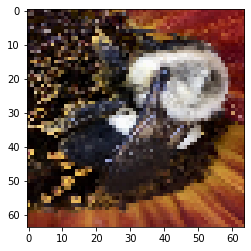

In [ ]:
img_path = 'bee0.jpg'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

[<tf.Tensor 'input_1_3:0' shape=(None, 64, 64, 3) dtype=float32>, <tf.Tensor 'conv2d_12_3/Relu:0' shape=(None, 60, 60, 32) dtype=float32>, <tf.Tensor 'conv2d_13_3/Relu:0' shape=(None, 60, 60, 32) dtype=float32>, <tf.Tensor 'conv2d_14_3/Relu:0' shape=(None, 58, 58, 32) dtype=float32>, <tf.Tensor 'conv2d_15_3/Relu:0' shape=(None, 58, 58, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_3_3/MaxPool:0' shape=(None, 29, 29, 64) dtype=float32>, <tf.Tensor 'dropout_3_3/cond/Identity:0' shape=(None, 29, 29, 64) dtype=float32>, <tf.Tensor 'conv2d_16_3/Relu:0' shape=(None, 27, 27, 64) dtype=float32>]


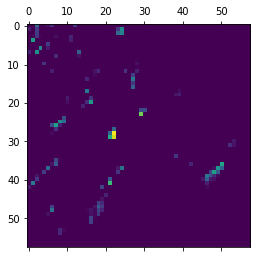

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
print(layer_outputs)
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[3]
plt.matshow(first_layer_activation[0,:,:,8], cmap='viridis')

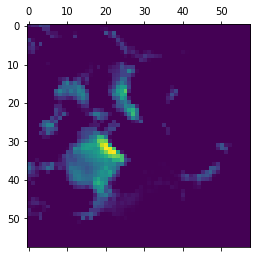

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

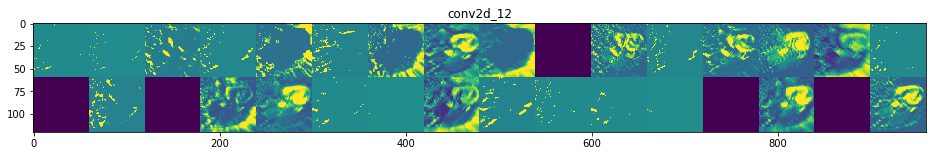

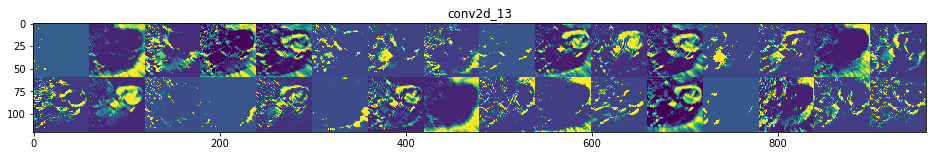

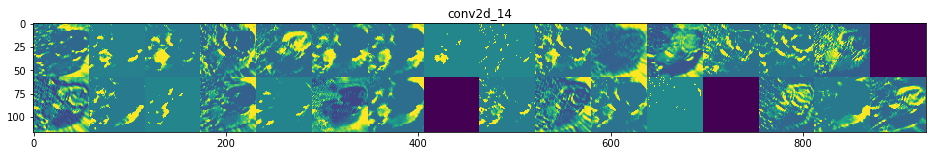

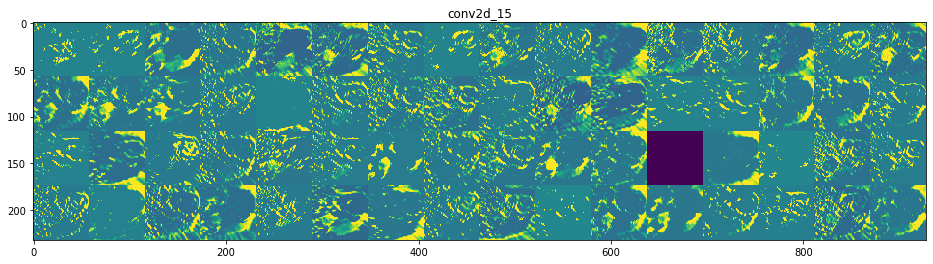

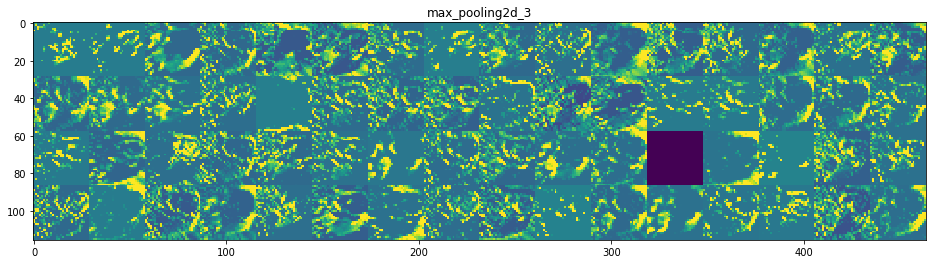

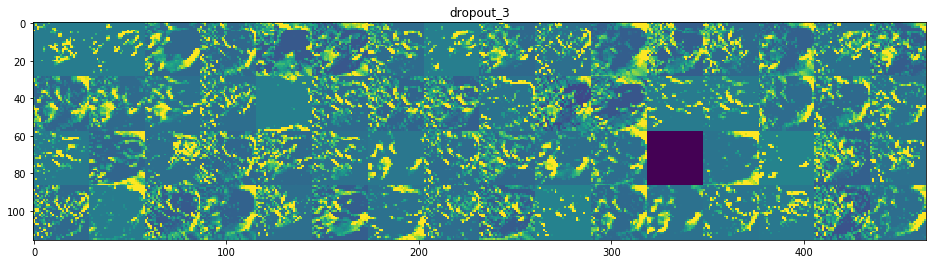

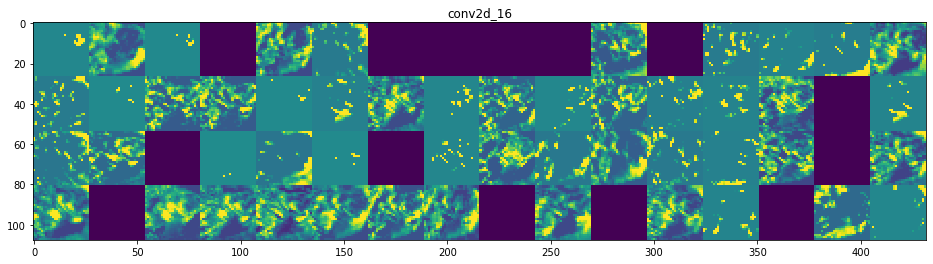

In [ ]:
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    try:
        assert(n_features > images_per_row)    
    except AssertionError:
        continue
    n_cols = n_features // images_per_row
    size = layer_activation.shape[1]
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    scale = 1./ size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x,0,1)
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

In [ ]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    #get the gradiant of the loss with regard to the input
    grads = K.gradients(loss, model.input)[0]
    #gradiant normalization 
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    #apply stochastic gradiant descent
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

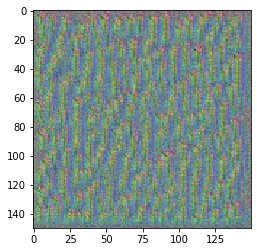

In [ ]:
plt.imshow(generate_pattern(layer_names[8], 2))